# Quora Question Pairs

## Problem Statement

1. Identify which questions asked on Quora are duplicates of questions that have already been asked. 
2. This could be useful to instantly provide answers to questions that have already been answered. 
3. We are tasked with predicting whether a pair of questions are duplicates or not. 

## Real world/Business Objectives and Constraints

1. The cost of a mis-classification can be very high.
2. We would want a probability of a pair of questions to be duplicates therefore we can choose any threshold of choice.
3. No strict latency concerns here
4. Interpretability is partially important.

## Machine Learning Problem

It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not.

## Performance Metric

Metric : Evaluated on the log loss between the predicted values and the ground truth.

# Exploratory Data Analysis 

In [79]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from bs4 import BeautifulSoup

In [69]:
# Reading train data using pandas

df = pd.read_csv('train.csv')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [70]:
df.shape

(404290, 6)

They are total 404290 datapoints and 6 features are in our dataset

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            404290 non-null  int64 
 1   qid1          404290 non-null  int64 
 2   qid2          404290 non-null  int64 
 3   question1     404289 non-null  object
 4   question2     404288 non-null  object
 5   is_duplicate  404290 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

id: Looks like a simple row ID
qid{1, 2}: The unique ID of each question in the pair
question{1, 2}: The actual textual contents of the questions.
is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

### Distribution of data points among output classes(duplicate or not duplicate)

is_duplicate
0    255027
1    149263
Name: id, dtype: int64
Question pairs which are not Similar (is_duplicate = 0):
   63.08%

Question pairs which are Similar (is_duplicate = 1):
   36.92%


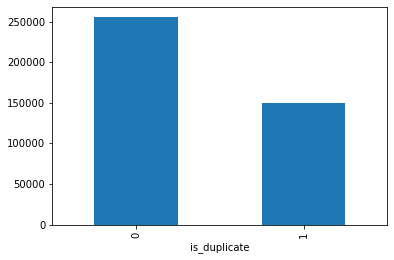

In [10]:
df.groupby('is_duplicate')['id'].count().plot.bar()
print(df.groupby('is_duplicate')['id'].count())

print('Question pairs which are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\nQuestion pairs which are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

## Number of unique questions

In [35]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
type(qids)

pandas.core.series.Series

In [38]:
unique_qs = len(np.unique(qids))
print ('Total number of  Unique Questions are: {}'.format(unique_qs))

Total number of  Unique Questions are: 537933


In [42]:
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of Questions repeated more than one time : {}'.format(qs_morethan_onetime))

Total number of Questions repeated more than one time : 111780


In [44]:
max_repeat_question = max(qids.value_counts())
print ('Max number of time a question repeated : {}'.format(max_repeat_question))

Max number of time a question repeated : 157


C:\Users\Dell\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
No handles with labels found to put in legend.


Total number of  Unique Questions are: 537933
Total number of Questions repeated more than one time : 111780


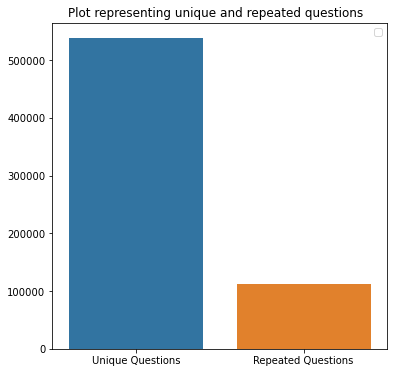

In [48]:
x = ["Unique Questions" , "Repeated Questions"]
y = [unique_qs , qs_morethan_onetime]

print ('Total number of  Unique Questions are: {}'.format(unique_qs))
print ('Total number of Questions repeated more than one time : {}'.format(qs_morethan_onetime))

plt.figure(figsize=(6, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.legend()

## Checking for Duplicates

In [54]:
# checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count()
print ("Number of duplicate questions : ",len(pair_duplicates) - len(df))

Number of duplicate questions :  0


## Number of occurrences of each question

Text(0, 0.5, 'Number of questions')

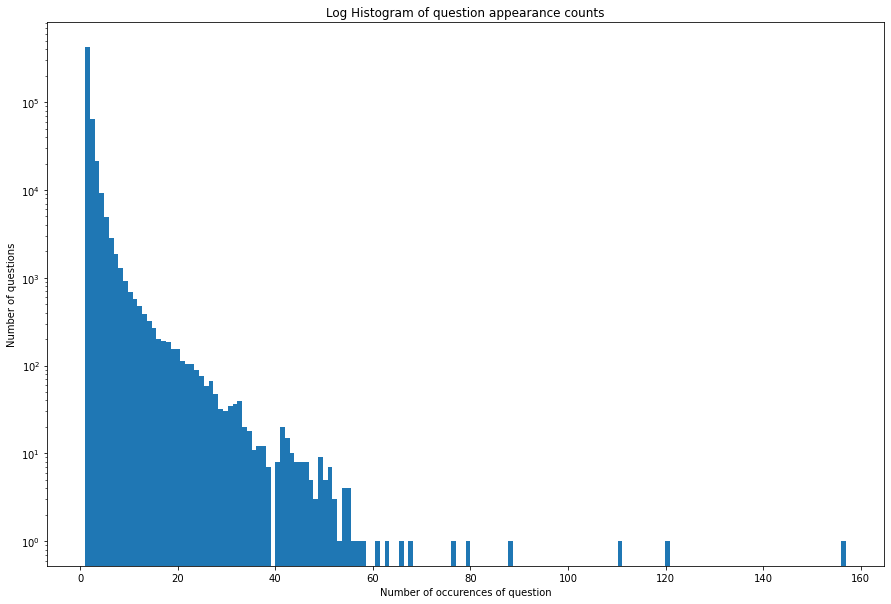

In [61]:
plt.figure(figsize=(15, 10))
plt.hist(qids.value_counts(),bins=160)
plt.yscale(value='log')
plt.title('Log Histogram of question appearance counts')
plt.xlabel('Number of occurences of question')
plt.ylabel('Number of questions')

## Checking for NULL values 


In [75]:
nan_rows = df[df.isnull().any(1)]
print('No.of null valued rows : ', len(nan_rows))
nan_rows

No.of null valued rows :  3


,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0
363362,363362,493340,493341,NaN,My Chinese name is Haichao Yu. What English na...,0


In [76]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print('No.of null valued rows : ', len(nan_rows))

No.of null valued rows :  0


## Basic Feature Extraction (before cleaning)

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [81]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0


## Analysis of some of the extracted features

In [82]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1


In [83]:
print ("No.of questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("No.of questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

No.of questions with minimum length [question1] : 67
No.of questions with minimum length [question2] : 24


##  Word Share distribution

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



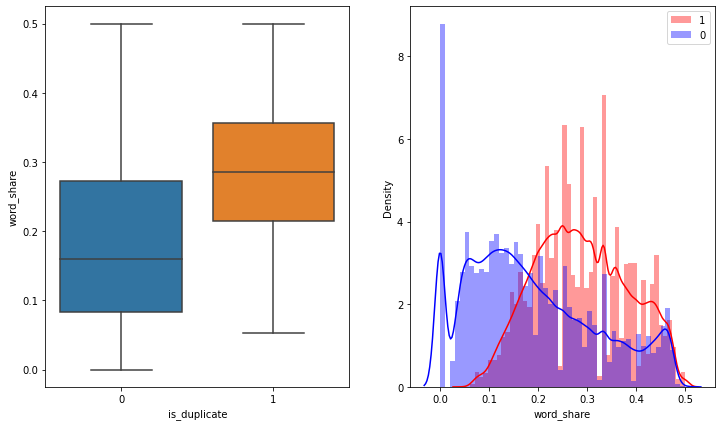

In [94]:
plt.figure(figsize=(12, 7))

plt.subplot(1,2,1)
sns.boxplot(x = 'is_duplicate', y = 'word_share', data = df[:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1]['word_share'][:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0]['word_share'][:] , label = "0" , color = 'blue')

plt.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and common no.of words of qid1 and qid2 is more when they are duplicate(Similar)

## Word Common distribution

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\Dell\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



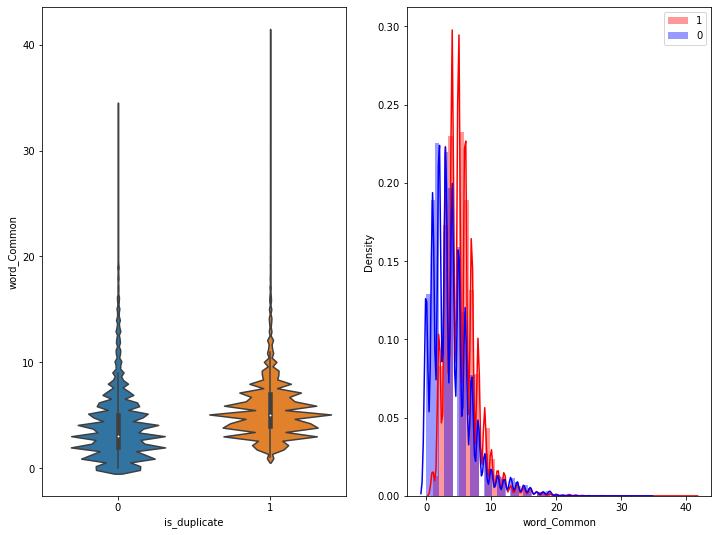

In [109]:
plt.figure(figsize=(12,9))

plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y = 'word_Common', data = df)

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate']==1]['word_Common'][:],label=1,color='red')
sns.distplot(df[df['is_duplicate']==0]['word_Common'][:],label=0,color='blue')
plt.legend()
plt.show()

The distributions of the word_Common feature in similar and non-similar questions are highly overlapping